In [1]:
import spectHR as cs
import pyhrv

In [2]:
DataSet = cs.SpectHRDataset("Example Data/SUB_002.xdf", 1, event_index = 0) 

INFO:pyxdf.pyxdf:Importing XDF file Example Data/SUB_002.xdf...
INFO:pyxdf.pyxdf:  performing clock synchronization...
INFO:pyxdf.pyxdf:  performing jitter removal...


In [3]:
bDataSet = cs.borderData(DataSet)
#bDataSet.ecg = bDataSet.ecg.slicetime(500,2100)

In [4]:
fDataSet = cs.filterECGData(bDataSet, 
                          {'filterType': 'highpass', 
                           'cutoff': 1})

In [9]:
tDataSet = cs.calcPeaks(bDataSet)

In [6]:
%matplotlib widget
GUI = cs.spectplot(tDataSet)

In [7]:
GUI

AppLayout(children=(HBox(children=(Dropdown(description='Mode:', layout=Layout(width='200px'), options=('Drag'…

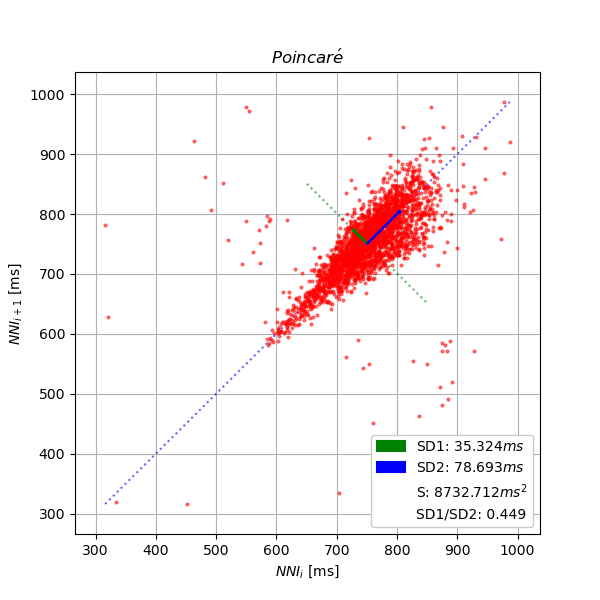

In [12]:
cs.poincare(tDataSet, 0, 1000)

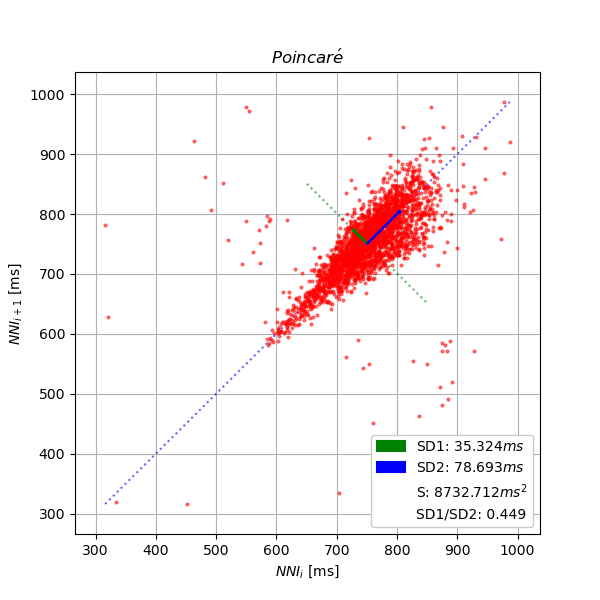

In [10]:
cs.poincare(tDataSet)